### Voronyi-Stepan-Camp-2025

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
fn='data/rt-polarity.neg'

with open(fn, "r",encoding='utf-8', errors='ignore') as f: 
    content = f.read()
texts_neg=  content.splitlines()
print ('len of texts_neg = {:,}'.format (len(texts_neg)))
for review in texts_neg[:5]:
    print ( '\n', review)

len of texts_neg = 5,331

 simplistic , silly and tedious . 

 it's so laddish and juvenile , only teenage boys could possibly find it funny . 

 exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable . 

 [garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation . 

 a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification . 


In [4]:
fn='data/rt-polarity.pos'

with open(fn, "r",encoding='utf-8', errors='ignore') as f:
    content = f.read()
texts_pos=  content.splitlines()
print ('len of texts_pos = {:,}'.format (len(texts_pos)))
for review in texts_pos[:5]:
    print ('\n', review)

len of texts_pos = 5,331

 the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . 

 the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth . 

 effective but too-tepid biopic

 if you sometimes like to go to the movies to have fun , wasabi is a good place to start . 

 emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one . 


In [5]:
df = pd.concat([
    pd.DataFrame({'text': texts_neg, 'label': 0}),
    pd.DataFrame({'text': texts_pos, 'label': 1})
], ignore_index=True)
print(f'Combined DataFrame shape: {df.shape}')

Combined DataFrame shape: (10662, 2)


In [6]:
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42)
print(f'Train samples: {len(train_df):,} | Test samples: {len(test_df):,}')

Train samples: 8,529 | Test samples: 2,133


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_test_tfidf  = tfidf.transform(test_df['text'])
y_train = train_df['label']
y_test  = test_df['label']

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_tfidf, y_train)
y_pred_lr = clf_lr.predict(X_test_tfidf)

print("Method 1: TF-IDF + Logistic Regression ")
print(f"Accuracy : {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_lr):.4f}")

Method 1: TF-IDF + Logistic Regression 
Accuracy : 0.7797
Precision: 0.7739
Recall   : 0.7899
F1-Score : 0.7818


In [9]:
import spacy
import numpy as np
from sklearn.linear_model import LogisticRegression

nlp = spacy.load("en_core_web_md")

def get_doc_vector(text):
    return nlp(text).vector

X_train_embed = np.vstack(train_df['text'].apply(get_doc_vector).values)
X_test_embed  = np.vstack(test_df['text'].apply(get_doc_vector).values)

clf_embed = LogisticRegression(max_iter=1000)
clf_embed.fit(X_train_embed, y_train)
y_pred_embed = clf_embed.predict(X_test_embed)

print("Method 2: Word Embeddings (spaCy) + Logistic Regression ")
print(f"Accuracy : {accuracy_score(y_test, y_pred_embed):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_embed):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_embed):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_embed):.4f}")

Method 2: Word Embeddings (spaCy) + Logistic Regression 
Accuracy : 0.6962
Precision: 0.7061
Recall   : 0.6717
F1-Score : 0.6885


In [11]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

labels = ["positive", "negative"]
test_snippets = test_df['text'].iloc[:100] 
true_labels = test_df['label'].iloc[:100].values
pred_labels = []

for text in test_snippets:
    result = classifier(text, candidate_labels=labels)
    pred = 1 if result['labels'][0] == 'positive' else 0
    pred_labels.append(pred)

print("Method 3: Transformer (BART) Zero-shot Classification")
print(f"Accuracy : {accuracy_score(true_labels, pred_labels):.4f}")
print(f"Precision: {precision_score(true_labels, pred_labels):.4f}")
print(f"Recall   : {recall_score(true_labels, pred_labels):.4f}")
print(f"F1-Score : {f1_score(true_labels, pred_labels):.4f}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu


Method 3: Transformer (BART) Zero-shot Classification
Accuracy : 0.8100
Precision: 0.8462
Recall   : 0.7174
F1-Score : 0.7765


In [14]:
results = pd.DataFrame([
    ['TF-IDF + LR', accuracy_score(y_test, y_pred_lr), precision_score(y_test, y_pred_lr), recall_score(y_test, y_pred_lr), f1_score(y_test, y_pred_lr)],
    ['SpaCy Embeddings + LR', accuracy_score(y_test, y_pred_embed), precision_score(y_test, y_pred_embed), recall_score(y_test, y_pred_embed), f1_score(y_test, y_pred_embed)],
    ['BART Zero-Shot', accuracy_score(true_labels, pred_labels), precision_score(true_labels, pred_labels), recall_score(true_labels, pred_labels), f1_score(true_labels, pred_labels)]
], columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1'])

results

,Method,Accuracy,Precision,Recall,F1
0,TF-IDF + LR,0.779653,0.773897,0.789869,0.781801
1,SpaCy Embeddings + LR,0.696203,0.706114,0.671670,0.688462
2,BART Zero-Shot,0.810000,0.846154,0.717391,0.776471


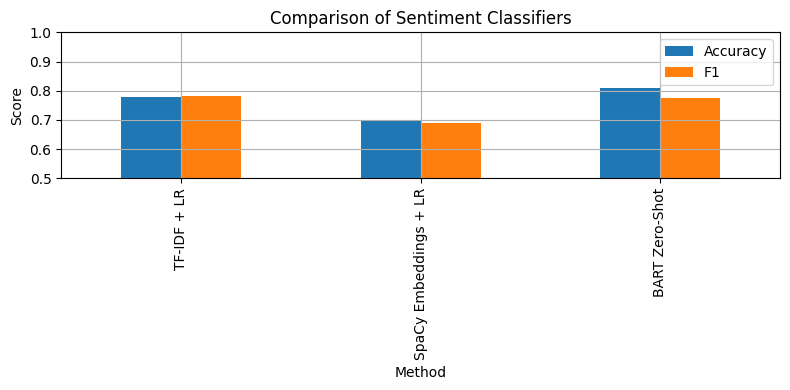

In [13]:
import matplotlib.pyplot as plt
results.set_index('Method')[['Accuracy', 'F1']].plot(kind='bar', ylim=(0.5, 1), figsize=(8,4))
plt.title("Comparison of Sentiment Classifiers")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()